In [ ]:
#Expected phase-width + Gaussian error
#RMS error
#Radius limit = 0.240 um under
#lookup table = 0, 0.065 to 0.237 um
#use scatterer_v3
#use v1_scatterers
#set 1600 x 1600 metaoptics

# Import computer stuff
import sys
print(sys.executable)

import logging
import os
import pickle
import time

from typing import List, Tuple
from scipy import ndimage

# Import open-source packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
# new code from Anna
from tensorflow.keras import optimizers


# Import Google Drive stuff
from google.colab import drive
drive.mount('/content/gdrive')

# Import src.tools
"""
 Tools for common use
"""

from typing import List, Tuple

import tensorflow as tf

/usr/bin/python3
Mounted at /content/gdrive


In [ ]:
# Load kernel, or create some kernel to test with
plotcount = 0
# kernel array is 16x3x7x7 : numkernel x RGB x X x Y
kernels = np.load('/content/gdrive/My Drive/ConvolutionalMetaOptics/Kernels_from_Jinlin/kernel_c_16_k_7_new.npy')
kernels.shape

(16, 3, 7, 7)

In [ ]:
kernel_index = 0 ## Load the first kernel to test with

kernel = kernels[kernel_index,:]
len(kernel[0,0,:])

7

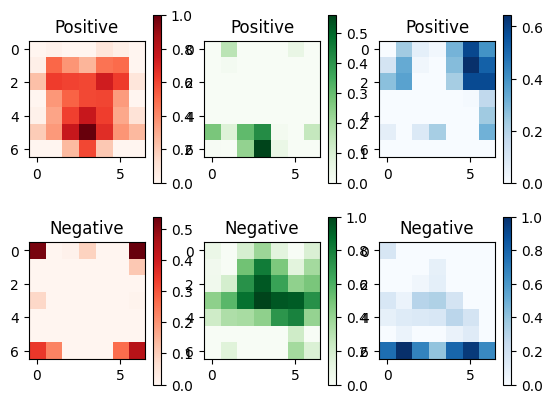

In [ ]:
kernel_index = 9 ## Load the first kernel to test with

kernel = kernels[kernel_index,:]
kernel_neg = kernel*0
kernel_pos = kernel*0

plotcount = 0

for n in range(0, len(kernel)): #n = 0,1,2 = Color R,G,B
  for i in range(0, len(kernel[0,:])): #i = 0,1,2 = X
      for j in range(0, len(kernel[0,0,:])): #j = 0,1,2 = Y
          if kernel[n,i,j] < 0:
              kernel_neg[n,i,j] = np.abs(kernel[n,i,j])
          else:
              kernel_pos[n,i,j] = kernel[n,i,j]

  # Normalize
  max_neg = np.amax(kernel_neg[n,:])
  max_pos = np.amax(kernel_pos[n,:])
  max = np.max([max_neg, max_pos])
  kernel_neg[n] = kernel_neg[n]/max
  kernel_pos[n] = kernel_pos[n]/max
  # Plot

  if n==0:
    plotcount = plotcount + 1
    plt.subplot(2,len(kernel),plotcount)
    plt.imshow(kernel_pos[n],cmap = 'Reds')
    plt.colorbar()
    plt.title("Positive")
    plt.subplot(2,len(kernel),plotcount+3)
    plt.imshow(kernel_neg[n],cmap = 'Reds')
    plt.colorbar()
    plt.title("Negative")
  if n==1:
    plotcount = plotcount + 1
    plt.subplot(2,len(kernel),plotcount)
    plt.imshow(kernel_pos[n],cmap = 'Greens')
    plt.colorbar()
    plt.title("Positive")
    plt.subplot(2,len(kernel),plotcount+3)
    plt.imshow(kernel_neg[n],cmap = 'Greens')
    plt.colorbar()
    plt.title("Negative")
  if n==2:
    plotcount = plotcount + 1
    plt.subplot(2,len(kernel),plotcount)
    plt.imshow(kernel_pos[n],cmap = 'Blues')
    plt.colorbar()
    plt.title("Positive")
    plt.subplot(2,len(kernel),plotcount+3)
    plt.imshow(kernel_neg[n],cmap = 'Blues')
    plt.colorbar()
    plt.title("Negative")


(1600, 1600)

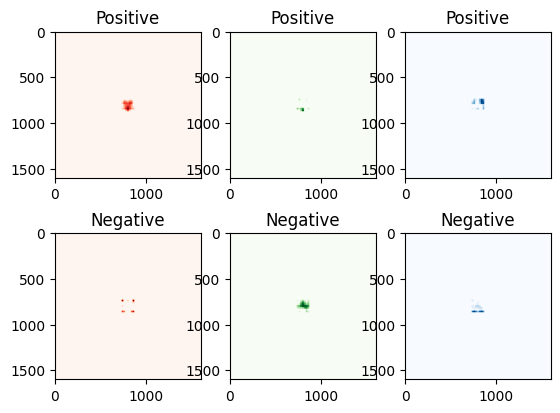

In [ ]:
# Expand and then pad to define the desired psf
#for n in range(0,len(kernels)):

## Scale factor setting
scale = 2;

# Red
numpx = scale * 10 # number of simulation pixels for each kernel pixel / previously 20 for MNIST
kernel_neg_expanded_R = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
kernel_pos_expanded_R = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
kernel_neg_expanded_G = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
kernel_pos_expanded_G = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
kernel_neg_expanded_B = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
kernel_pos_expanded_B = np.zeros((numpx*len(kernel[0,:]),numpx*len(kernel[0,0,:])))
for i in range(0,len(kernel[0,:])):
    for j in range(0,len(kernel[0,0,:])):
        kernel_neg_expanded_R[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_neg[0,i,j]
        kernel_pos_expanded_R[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_pos[0,i,j]
        kernel_neg_expanded_G[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_neg[1,i,j]
        kernel_pos_expanded_G[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_pos[1,i,j]
        kernel_neg_expanded_B[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_neg[2,i,j]
        kernel_pos_expanded_B[i*numpx:(i+1)*numpx,j*numpx:(j+1)*numpx] = kernel_pos[2,i,j]

# pad to 1600 by 1600 array
numpad = 800-scale*35 #35 came from 7 * 10 /2
kernel_neg_expanded_R = (np.pad(kernel_neg_expanded_R,(numpad,numpad),'constant',constant_values=(0,0)))
kernel_pos_expanded_R = (np.pad(kernel_pos_expanded_R,(numpad,numpad),'constant',constant_values=(0,0)))
kernel_neg_expanded_B = (np.pad(kernel_neg_expanded_B,(numpad,numpad),'constant',constant_values=(0,0)))
kernel_pos_expanded_B = (np.pad(kernel_pos_expanded_B,(numpad,numpad),'constant',constant_values=(0,0)))
kernel_neg_expanded_G = (np.pad(kernel_neg_expanded_G,(numpad,numpad),'constant',constant_values=(0,0)))
kernel_pos_expanded_G = (np.pad(kernel_pos_expanded_G,(numpad,numpad),'constant',constant_values=(0,0)))

# Save the desired PSF
#np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/Kernels_from_Jinlin/Kernel0_neg_expanded.npy',kernel_neg_expanded)

plt.subplot(2,3,1)
plt.imshow(kernel_pos_expanded_R,cmap = 'Reds')
plt.title("Positive")
plt.subplot(2,3,2)
plt.imshow(kernel_pos_expanded_G,cmap = 'Greens')
plt.title("Positive")
plt.subplot(2,3,3)
plt.imshow(kernel_pos_expanded_B,cmap = 'Blues')
plt.title("Positive")

plt.subplot(2,3,4)
plt.imshow(kernel_neg_expanded_R,cmap = 'Reds')
plt.title("Negative")
plt.subplot(2,3,5)
plt.imshow(kernel_neg_expanded_G,cmap = 'Greens')
plt.title("Negative")
plt.subplot(2,3,6)
plt.imshow(kernel_neg_expanded_B,cmap = 'Blues')
plt.title("Negative")

kernel_pos_expanded_R.shape



In [ ]:
# Set the simulation arguments
dtype = {'real': tf.float32, 'comp': tf.complex64, }
sim_args_R = {
    'wavelength': 635e-9, #R: 635, G: 532, B: 450
    'dd': 586e-9, # simulation grid size
    'numpx': 1600,  # number of pixels in array, without padding
    } # size of lens
sim_args_R = {
    **sim_args_R,
    'k': 2. * np.pi / sim_args_R['wavelength'],
    'spacing_start_to_ms1': 0.5e-3, #2.0e-3,
    'spacing_ms1_to_detector': 2.4e-3, #20e-3,
    'array_shape': (sim_args_R['numpx'], sim_args_R['numpx'],),
    'lens_aperture': sim_args_R['numpx']*sim_args_R['dd'],
    'dtype': dtype['comp'],
    }

sim_args_G = {
    'wavelength': 532e-9, #R: 635, G: 532, B: 450
    'dd': 586e-9, # simulation grid size
    'numpx': 1600,  # number of pixels in array, without padding
    } # size of lens
sim_args_G = {
    **sim_args_G,
    'k': 2. * np.pi / sim_args_G['wavelength'],
    'spacing_start_to_ms1': 0.5e-3, #2.0e-3,
    'spacing_ms1_to_detector': 2.4e-3, #20e-3,
    'array_shape': (sim_args_G['numpx'], sim_args_G['numpx'],),
    'lens_aperture': sim_args_G['numpx']*sim_args_G['dd'],
    'dtype': dtype['comp'],
    }

sim_args_B = {
    'wavelength': 450e-9, #R: 635, G: 532, B: 450
    'dd': 586e-9, # simulation grid size
    'numpx': 1600,  # number of pixels in array, without padding
    } # size of lens
sim_args_B = {
    **sim_args_B,
    'k': 2. * np.pi / sim_args_B['wavelength'],
    'spacing_start_to_ms1': 0.5e-3, #2.0e-3,
    'spacing_ms1_to_detector': 2.4e-3, #20e-3,
    'array_shape': (sim_args_B['numpx'], sim_args_B['numpx'],),
    'lens_aperture': sim_args_B['numpx']*sim_args_B['dd'],
    'dtype': dtype['comp'],
    }

field_args_R = {'array_size' : sim_args_R['numpx'], 'dtype' : dtype['comp']}
field_args_G = {'array_size' : sim_args_G['numpx'], 'dtype' : dtype['comp']}
field_args_B = {'array_size' : sim_args_B['numpx'], 'dtype' : dtype['comp']}

# Back-propagate to get initial guess

# use angular spectrum propagation to check
# Propagate a constant light field though the meta-optic
def asprop(e, z, λ, d):
    """
    Angular Spectrum method of propagation on unshifted complex field (unitless)
    INPUTS:
        e: [complexe array] amplitude field; e.g.: E*exp(j*phi)
        z: distance to propagation plane; e.g.: 1e3
        λ: [float] wavelength > 0
        d: [tuple] size of meta-cell (nx>0, ny>0); size of pixels
    OUTPUT:
        stack of complex field in propagation plane(s)
    """
    # invert field phase for back-propagation
    if np.sign(z) < 0:
        e = np.conjugate(e)

    # compute angular spectrum
    E = np.fft.fft2(e)

    # extract grid parameters
    nx, ny = e.shape
    dx, dy = d

    # get k-grid (spatial frequency); real mode:propagating; complex mode: evanescent
    u = np.fft.fftfreq(n=nx, d=dx) # compute the spatial frequencies directly, saves time and power
    v = np.fft.fftfreq(n=ny, d=dy)
    V, U = np.meshgrid(v, u)
    W = np.sqrt(0j + 1/λ ** 2 - U ** 2 - V ** 2).real # the pure imaginary values are evanescent waves which are not to be taken into account into the propagation; so by adding the .real, you convert pure imaginary to 0 values

    # calculate diffraction plane angular spectrum
    Ez = E * np.exp(1j * 2 * np.pi * W * np.abs(z))

    # retrieve diffraction-plane real-space field
#     ez = np.fft.ifft2(np.fft.ifftshift(Ez))
    ez = np.fft.ifft2(Ez)

    return ez




Text(0.5, 1.0, 'Blue')

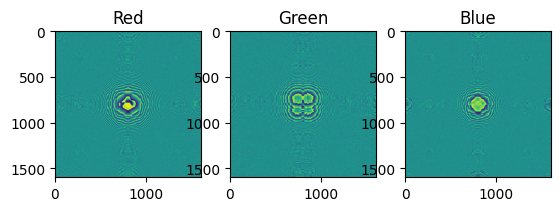

In [ ]:
plt.subplot(1,3,1)
backprop_R = asprop(kernel_neg_expanded_R,-sim_args_R['spacing_ms1_to_detector'],sim_args_R['wavelength'],(sim_args_R['dd'],sim_args_R['dd']))
backphase_R = np.angle(np.real(backprop_R) + 1j * np.imag(backprop_R))
#backphase_R = tf.cast(backphase_R, dtype=tf.float32)
plt.imshow(backphase_R) # extent[xmin,xmax,ymin,ymax]
plt.title("Red")

plt.subplot(1,3,2)
backprop_G = asprop(kernel_neg_expanded_G,-sim_args_G['spacing_ms1_to_detector'],sim_args_G['wavelength'],(sim_args_G['dd'],sim_args_G['dd']))
backphase_G = np.angle(np.real(backprop_G) + 1j * np.imag(backprop_G))
#backphase_G = tf.cast(backphase_G, dtype=tf.float32)
plt.imshow(backphase_G) # extent[xmin,xmax,ymin,ymax]
plt.title("Green")

plt.subplot(1,3,3)
backprop_B = asprop(kernel_neg_expanded_B,-sim_args_B['spacing_ms1_to_detector'],sim_args_B['wavelength'],(sim_args_B['dd'],sim_args_B['dd']))
backphase_B = np.angle(np.real(backprop_B) + 1j * np.imag(backprop_B))
#backphase_B = tf.cast(backphase_B, dtype=tf.float32)
plt.imshow(backphase_B) # extent[xmin,xmax,ymin,ymax]
plt.title("Blue")

In [ ]:
print(backphase_B)

[[ 2.32922357 -0.7329541  -0.87958698 ... -0.87991539 -0.72856544
   2.32212639]
 [-0.8877672   2.4050585   2.23172387 ...  2.22751642  2.29191291
  -0.83664954]
 [-0.86443586  2.38732037  2.21463205 ...  2.22867547  2.3569389
  -0.84640457]
 ...
 [-0.96664284  2.13787622  2.110184   ...  2.04758504  2.25154433
  -1.06161836]
 [-0.73359725  2.45823602  2.33664056 ...  2.32232097  2.49530386
  -0.76432434]
 [ 2.18614026 -0.91034592 -1.00237463 ... -1.0409462  -0.89463997
   2.15292722]]


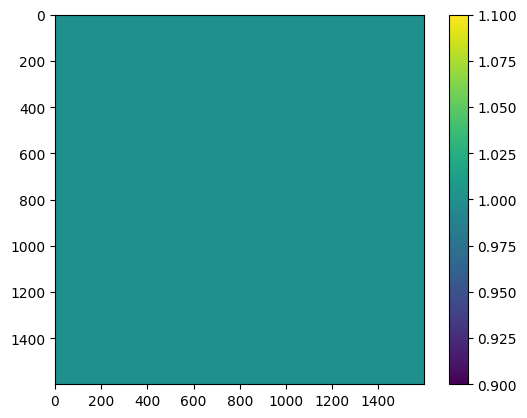

In [ ]:
# START OVER CLEAN - new code


#initial_field = tf.Tensor(tf.ones(shape=sim_args['array_shape'], dtype=tf.complex64))
# Set the initial field generator - constant amplitude field
class OneDPhasorField(tf.Module):
    def __init__(self, array_size, dtype):
        #assert isinstance(pixel_width, int)
        #assert isinstance(pixel_height, int)
        #assert isinstance(pixel_spacing, int)
        assert isinstance(array_size,int)
        assert dtype == tf.complex64 or dtype == tf.complex128, "Dtype must be a complex datatype"

        self.dtype = dtype
        self.field = tf.Variable(tf.ones(shape=(array_size,array_size), dtype=dtype), trainable=False)  # Variable supports slice assign

    @tf.function
    def __call__(self):
        return self.field

field_generator_R = OneDPhasorField(**field_args_R)
field_generator_G = OneDPhasorField(**field_args_G)
field_generator_B = OneDPhasorField(**field_args_B)
# Plot the initial fields
field_set_R = field_generator_R()
field_set_G = field_generator_G()
field_set_B = field_generator_B()
plot_field_set_R = tf.abs(field_set_R).numpy()
plot_field_set_G = tf.abs(field_set_G).numpy()
plot_field_set_B = tf.abs(field_set_B).numpy()
plt.imshow(plot_field_set_R)
plt.colorbar()

In [ ]:
# Initialize and define metasurfaces: need split_complex and complex_initializer_random
def split_complex(c):
    return tf.math.real(c), tf.math.imag(c)
# element-wise multiply complex tensors `m1` and `m2`
def complex_mul(m1_real, m1_imag, m2_real, m2_imag):
    return m1_real * m2_real - m1_imag * m2_imag, m1_real * m2_imag + m1_imag * m2_real
def complex_initializer_random(shape):
    """
    Generates a complex valued tensor with values that are distributed with uniform density in the unit circle of the
    complex plane
    """
    return np.sqrt(np.random.rand(*shape)) * np.exp(1j * np.random.rand(*shape) * np.pi * 2)


# initialize and define metasurfaces
#metasurface1_phase = tf.Variable(tf.random.uniform(shape=sim_args['array_shape'], maxval=np.pi*2., dtype=dtype['real']),
 #       trainable=True,
 #   )
"""
metasurface1_phase_R = tf.Variable(tf.random.uniform(shape=sim_args_R['array_shape'], maxval=np.pi*2, dtype=dtype['real']),
                                   trainable=False,
)
metasurface1_phase_G = tf.Variable(tf.random.uniform(shape=sim_args_G['array_shape'], maxval=np.pi*2, dtype=dtype['real']),
                                   trainable=False,
)
metasurface1_phase_B = tf.Variable(tf.random.uniform(shape=sim_args_B['array_shape'], maxval=np.pi*2, dtype=dtype['real']),
                                   trainable=False,
)"""
metasurface1_phase_R = tf.Variable(backphase_R,trainable=False,dtype=dtype['real'])
metasurface1_phase_G = tf.Variable(backphase_G,trainable=False,dtype=dtype['real'])
metasurface1_phase_B = tf.Variable(backphase_B,trainable=False,dtype=dtype['real'])

# define the desired psf
desired_psf_R = tf.convert_to_tensor(kernel_neg_expanded_R, dtype = tf.float32)
desired_psf_G = tf.convert_to_tensor(kernel_neg_expanded_G, dtype = tf.float32)
desired_psf_B = tf.convert_to_tensor(kernel_neg_expanded_B, dtype = tf.float32)
desired_psf = (desired_psf_R,desired_psf_G,desired_psf_B)
print(kernel_neg_expanded_R)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(desired_psf_R)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(1600, 1600), dtype=float32)


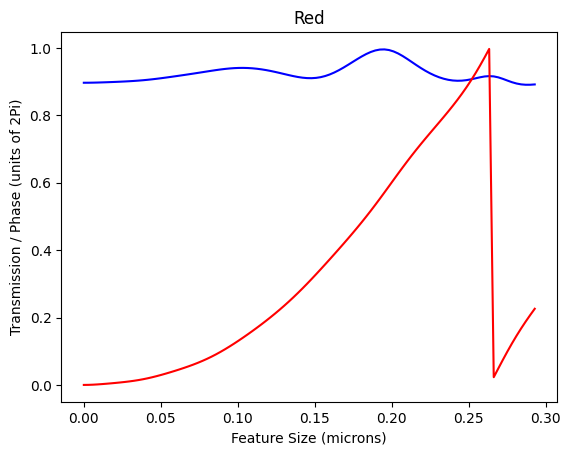

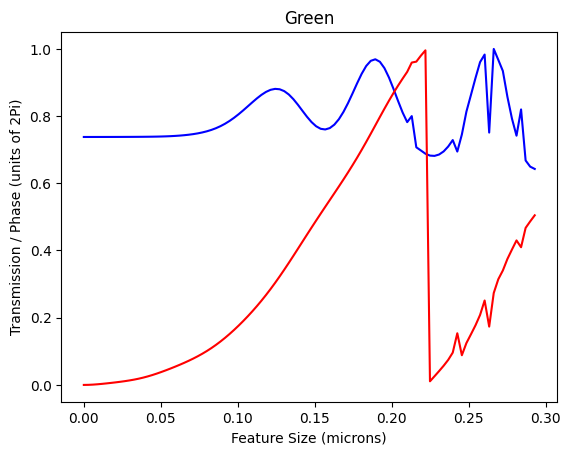

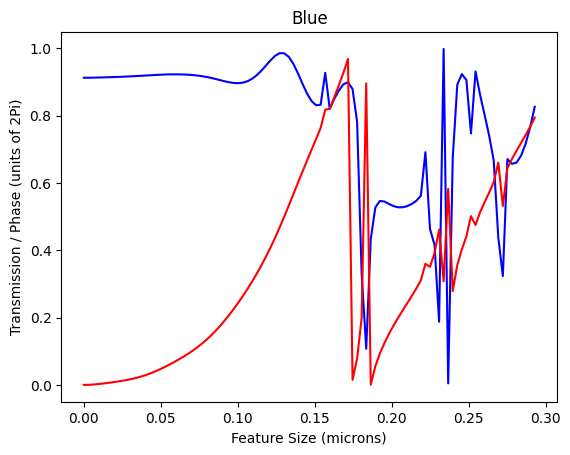

In [ ]:
rcwa_R = np.loadtxt('/content/gdrive/My Drive/ConvolutionalMetaOptics/Vis_Scatterer_Designs/SiN_h750nm_p293nm_R.txt')
data_hf_list_R=rcwa_R[:,0]
data_phase_R=rcwa_R[:,1]
data_amp_R = rcwa_R[:,2]
rcwa_G = np.loadtxt('/content/gdrive/My Drive/ConvolutionalMetaOptics/Vis_Scatterer_Designs/SiN_h750nm_p293nm_G.txt')
data_hf_list_G=rcwa_G[:,0]
data_phase_G=rcwa_G[:,1]
data_amp_G = rcwa_G[:,2]
rcwa_B = np.loadtxt('/content/gdrive/My Drive/ConvolutionalMetaOptics/Vis_Scatterer_Designs/SiN_h750nm_p293nm_B.txt')
data_hf_list_B=rcwa_B[:,0]
data_phase_B=rcwa_B[:,1]
data_amp_B = rcwa_B[:,2]


# Plot results
plt.subplots(1,1)
plt.plot(data_hf_list_R,data_amp_R,'blue')
plt.plot(data_hf_list_R,data_phase_R,'red')
plt.xlabel("Feature Size (microns)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.title("Red")

plt.subplots(1,1)
plt.plot(data_hf_list_G,data_amp_G,'blue')
plt.plot(data_hf_list_G,data_phase_G,'red')
plt.xlabel("Feature Size (microns)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.title("Green")

plt.subplots(1,1)
plt.plot(data_hf_list_B,data_amp_B,'blue')
plt.plot(data_hf_list_B,data_phase_B,'red')
plt.xlabel("Feature Size (microns)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.title("Blue")

plt.show()



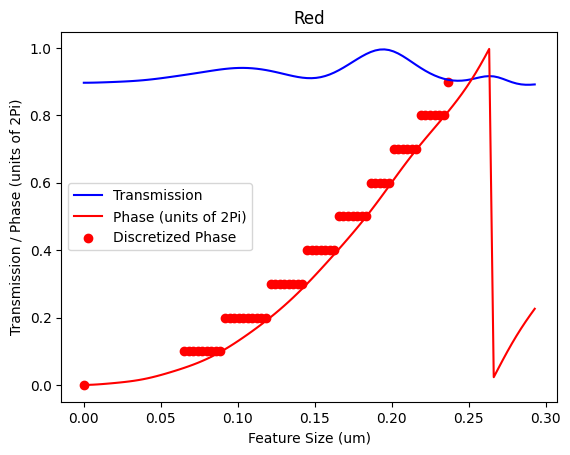

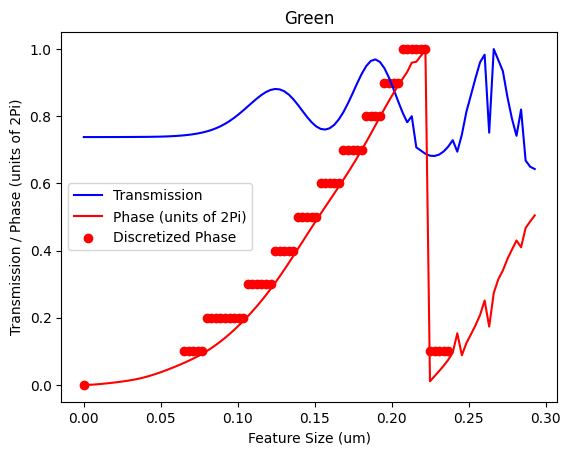

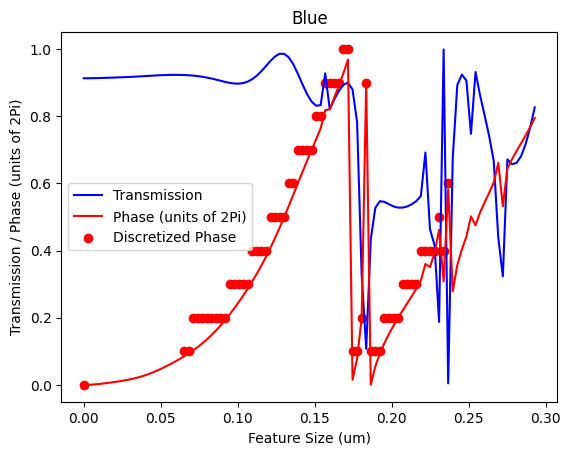

In [ ]:
# Discretize the Phase (from Huang's code)
select = np.array([0])
start = [22]
stop = [80]
for i in range(0,len(start)):
    select = np.concatenate((select,np.arange(start[i],stop[i]+1,1)))

def discretize_phase_mask(phase_mask_wrapped, num_of_bins):
    """
    input:
            an 2D numpy wrapped phase mask in radians
            desired number of bins
    return:
            2D numpy discretized phase array
    """
    phase_mask = phase_mask_wrapped
    bins = np.linspace(0, 1, num_of_bins + 1)
    index_array = np.digitize(phase_mask, bins, right=True)
    discretized_phase_array = index_array/num_of_bins
    return discretized_phase_array

# Define ranges to use in [start,stop] pairs
# use hf 0 as 0 phase feature
data_phase_discrete_R = discretize_phase_mask(data_phase_R,10)
data_phase_discrete_G = discretize_phase_mask(data_phase_G,10)
data_phase_discrete_B = discretize_phase_mask(data_phase_B,10)
#start = 60
#stop = 233

data_phase_discrete2_R = data_phase_discrete_R[select]
data_hf_list2_R = data_hf_list_R[select]
# Plot results
plt.subplots(1,1)
plt.plot(data_hf_list_R,data_amp_R,'blue')
plt.plot(data_hf_list_R,data_phase_R,'red')
#plt.plot(L_hf_fdtd,((L_phase_unwrapped_fdtd-L_phase_unwrapped_fdtd[0])%(2*np.pi))/(2*np.pi),'maroon',linestyle='dotted')
plt.scatter(data_hf_list2_R,data_phase_discrete2_R,color='r')
plt.xlabel("Feature Size (um)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.legend(["Transmission","Phase (units of 2Pi)","Discretized Phase"])
plt.title("Red")

data_phase_discrete2_G = data_phase_discrete_G[select]
data_hf_list2_G = data_hf_list_G[select]
# Plot results
plt.subplots(1,1)
plt.plot(data_hf_list_G,data_amp_G,'blue')
plt.plot(data_hf_list_G,data_phase_G,'red')
#plt.plot(L_hf_fdtd,((L_phase_unwrapped_fdtd-L_phase_unwrapped_fdtd[0])%(2*np.pi))/(2*np.pi),'maroon',linestyle='dotted')
plt.scatter(data_hf_list2_G,data_phase_discrete2_G,color='r')
plt.xlabel("Feature Size (um)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.legend(["Transmission","Phase (units of 2Pi)","Discretized Phase"])
plt.title("Green")

data_phase_discrete2_B = data_phase_discrete_B[select]
data_hf_list2_B = data_hf_list_B[select]
# Plot results
plt.subplots(1,1)
plt.plot(data_hf_list_B,data_amp_B,'blue')
plt.plot(data_hf_list_B,data_phase_B,'red')
#plt.plot(L_hf_fdtd,((L_phase_unwrapped_fdtd-L_phase_unwrapped_fdtd[0])%(2*np.pi))/(2*np.pi),'maroon',linestyle='dotted')
plt.scatter(data_hf_list2_B,data_phase_discrete2_B,color='r')
plt.xlabel("Feature Size (um)")
plt.ylabel("Transmission / Phase (units of 2Pi)")
plt.legend(["Transmission","Phase (units of 2Pi)","Discretized Phase"])
plt.title("Blue")

plt.show()

In [ ]:
from tqdm import tqdm
import tqdm as tqdmpi

def generate_radius_array(r2p_lookup_table, phase_mask):
    """
    takes in the radius (μm) to phase lookup table, and a 2D phase mask (wrapped in units of 2Pi),
    return: a 2D (numpy) radius array (cartesian).

    road map:
        unique_phase ->
        iterate over each unique phase ->
        find the closest radius on the r2p_lookup_table ->
        return radius array
    """
    radius_table, phase_table = r2p_lookup_table
    #unique_phase = np.unique(phase_mask)
    radius_array = np.zeros(np.shape(phase_mask))

#    for value_in_unique_phase in tqdm(unique_phase): #tqdm just adds a progress bar; not essential to running the code
# Huang's code: iterate by unique phases
#        # lets find the absolute distance between the ideal phase and the wrapped phase mask
#        distance = value_in_unique_phase - phase_table
#        phase_distance = np.sin(distance/2)**2
#        smallest_difference_index = phase_distance.argmin()
#        closest_radius = radius_table[smallest_difference_index]
#        radius_array[phase_mask==value_in_unique_phase] = closest_radius
#    return radius_array


# Faster: iterate by index straightforwardly
    for n in tqdm(range(0,len(phase_mask))): #tdqm just adds a progress bar; not essential to running the code
        for m in range(0,len(phase_mask[1])):
            distance = phase_mask[n,m] - phase_table
            phase_distance = np.sin(distance/2)**2
            smallest_difference_index = phase_distance.argmin()
            closest_radius = radius_table[smallest_difference_index]
            radius_array[n,m] = closest_radius
    return radius_array
#np.savetxt('./radius_array.txt',radius_array2)
# List the discretized phase values


In [ ]:
import tensorflow as tf
from tqdm import tqdm

def generate_radius_array_TF(r2p_lookup_table, phase_mask):
    """
    takes in the radius (μm) to phase lookup table, and a 2D phase mask (wrapped in units of 2Pi),
    return: a 2D (tensorflow) radius array (cartesian).

    road map:
        unique_phase ->
        iterate over each unique phase ->
        find the closest radius on the r2p_lookup_table ->
        return radius array
    """
    radius_table, phase_table = r2p_lookup_table

    radius_array = tf.zeros(tf.shape(phase_mask), dtype=tf.float32)

    for n in tqdm(range(0, tf.shape(phase_mask)[0])):
        for m in range(0, tf.shape(phase_mask)[1]):
            distance = phase_mask[n, m] - phase_table
            phase_distance = tf.math.square(tf.math.sin(distance / 2.0))
            smallest_difference_index = tf.argmin(phase_distance, axis=0)
            closest_radius = tf.gather(radius_table, smallest_difference_index)
            radius_array = tf.tensor_scatter_nd_update(radius_array, [(n, m)], [closest_radius])

    return radius_array


In [ ]:
#def unique(list1):
#
#    # initialize a null list
#    unique_list = []
#
#    # traverse for all elements
#    for x in list1:
#        # check if exists in unique_list or not
#        if x not in unique_list:
#            unique_list.append(x)
#    # print list
#    print(unique_list)

In [ ]:
#print(data_phase_discrete2)
#print(data_hf_list2)

In [ ]:
phase_mask_wrapped_R = ((metasurface1_phase_R)%(2*np.pi))/(2*np.pi)
#lookup_table = np.array([data_hf_list2,data_phase_discrete2])
lookup_table_R = tf.convert_to_tensor([data_hf_list2_R, data_phase_R[select]],dtype=tf.float32)
lookup_table_G = tf.convert_to_tensor([data_hf_list2_G, data_phase_G[select]],dtype=tf.float32)
lookup_table_B = tf.convert_to_tensor([data_hf_list2_B, data_phase_B[select]],dtype=tf.float32)
#lookup_table_amp_R = np.array([data_hf_list2_R,data_amp_R[select]])
#lookup_table_amp_G = np.array([data_hf_list2_G,data_amp_R[select]])
#lookup_table_amp_B = np.array([data_hf_list2_B,data_amp_R[select]])

radius_array_R = generate_radius_array_TF(lookup_table_R,phase_mask_wrapped_R) # This generates the array of pillar sizes
#radius_array_R = tf.Variable(radius_array_R,trainable=True,dtype=tf.float32)


100%|██████████| 1600/1600 [1:13:56<00:00,  2.77s/it]


In [ ]:
print(lookup_table_R)

tf.Tensor(
[[0.         0.06511111 0.06807071 0.0710303  0.0739899  0.07694949
  0.07990909 0.08286869 0.08582828 0.08878788 0.09174748 0.09470707
  0.09766667 0.10062626 0.10358586 0.10654546 0.10950505 0.11246464
  0.11542425 0.11838384 0.12134343 0.12430303 0.12726262 0.13022222
  0.13318183 0.13614142 0.13910101 0.14206061 0.1450202  0.1479798
  0.15093939 0.15389898 0.1568586  0.15981819 0.16277778 0.16573738
  0.16869697 0.17165656 0.17461616 0.17757575 0.18053535 0.18349496
  0.18645455 0.18941414 0.19237374 0.19533333 0.19829293 0.20125252
  0.20421211 0.20717172 0.21013132 0.21309091 0.2160505  0.2190101
  0.2219697  0.22492929 0.22788888 0.23084849 0.23380809 0.23676768]
 [0.         0.05053862 0.05522203 0.06016785 0.06543141 0.07106602
  0.07711679 0.08361532 0.09057586 0.09799363 0.10584569 0.11409468
  0.12269516 0.13160129 0.14077434 0.15018822 0.1598319  0.16970873
  0.17983378 0.19023018 0.20092551 0.21194918 0.22333007 0.23509432
  0.24726284 0.25984803 0.27285054 0.2

In [ ]:
radius_array_R = tf.Variable(radius_array_R,trainable=True,dtype=tf.float32)
print(radius_array_R)

<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.23676768, 0.1450202 , 0.17165656, ..., 0.17165656, 0.22492929,
        0.23676768],
       [0.15389898, 0.0710303 , 0.23084849, ..., 0.22788888, 0.23676768,
        0.16277778],
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.18941414,
        0.17461616],
       ...,
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.19533333,
        0.17757575],
       [0.15093939, 0.06511111, 0.20421211, ..., 0.20421211, 0.08286869,
        0.13614142],
       [0.23676768, 0.15389898, 0.17165656, ..., 0.17461616, 0.0739899 ,
        0.23676768]], dtype=float32)>


In [ ]:
print(metasurface1_phase_R)
print(phase_mask_wrapped_R)
print(radius_array_R)


<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[-0.46695665,  1.8652846 ,  2.7027357 , ...,  2.7568786 ,
        -1.5691456 , -0.4717269 ],
       [ 2.1243396 ,  0.372436  , -1.3930823 , ..., -1.5298005 ,
        -0.0335745 ,  2.404689  ],
       [ 2.8442917 , -1.9817555 , -0.25484946, ..., -0.1814738 ,
        -2.9510407 ,  2.8165607 ],
       ...,
       [ 2.8778553 , -2.031326  , -0.17941275, ..., -0.1607744 ,
        -2.714666  ,  2.9221559 ],
       [ 2.06025   ,  0.3052581 , -2.333797  , ..., -2.3738816 ,
         0.5078083 ,  1.6038277 ],
       [-0.3722525 ,  2.1807008 ,  2.7077308 , ...,  2.8329525 ,
         0.41932935, -0.52777684]], dtype=float32)>
tf.Tensor(
[[0.92568153 0.29686925 0.43015373 ... 0.43877086 0.75026274 0.92492235]
 [0.33809912 0.05927503 0.7782841  ... 0.7565247  0.99465644 0.38271815]
 [0.45268306 0.6845938  0.95943946 ... 0.97111756 0.5303273  0.44826955]
 ...
 [0.4580249  0.67670447 0.97144556 ... 0.97441196 0.5679475  0.465075

In [ ]:

def generate_phase_array(r2p_lookup_table1,r2p_lookup_table2, r2p_lookup_table3, radius_mask):
    """
    takes in the radius (μm) to phase lookup table, and a 2D phase mask (wrapped in units of 2Pi),
    return: a 2D (numpy) radius array (cartesian).

    road map:
        unique_phase ->
        iterate over each unique phase ->
        find the closest radius on the r2p_lookup_table ->
        return radius array
    """
    radius_table, phase_table1 = r2p_lookup_table1
    #unique_phase = np.unique(phase_mask)
    phase_array1 = np.zeros(np.shape(radius_mask))

    radius_table, phase_table2 = r2p_lookup_table2
    #unique_phase = np.unique(phase_mask)
    phase_array2 = np.zeros(np.shape(radius_mask))

    radius_table, phase_table3 = r2p_lookup_table3
    #unique_phase = np.unique(phase_mask)
    phase_array3 = np.zeros(np.shape(radius_mask))

#    for value_in_unique_phase in tqdm(unique_phase): #tqdm just adds a progress bar; not essential to running the code
# Huang's code: iterate by unique phases
#        # lets find the absolute distance between the ideal phase and the wrapped phase mask
#        distance = value_in_unique_phase - phase_table
#        phase_distance = np.sin(distance/2)**2
#        smallest_difference_index = phase_distance.argmin()
#        closest_radius = radius_table[smallest_difference_index]
#        radius_array[phase_mask==value_in_unique_phase] = closest_radius
#    return radius_array


# Faster: iterate by index straightforwardly
    for n in tqdm(range(0,len(radius_mask[:]))): #tdqm just adds a progress bar; not essential to running the code
        for m in range(0,len(radius_mask[1,:])):
            distance = radius_mask[n,m] - radius_table
            radius_distance = np.sin(distance/2)**2
            smallest_difference_index = radius_distance.argmin()
            closest_phase1 = phase_table1[smallest_difference_index]
            closest_phase2 = phase_table2[smallest_difference_index]
            closest_phase3 = phase_table3[smallest_difference_index]
            phase_array1[n,m] = closest_phase1
            phase_array2[n,m] = closest_phase2
            phase_array3[n,m] = closest_phase3
    return phase_array1, phase_array2, phase_array3

In [ ]:
print(len(radius_array_R[1,:]))

1600


In [ ]:
# Redefine function in tensorflow
pitch = sim_args_R['dd']*1e6/2 #micron

def generate_phase_array_TF(radius_mask):
    radius_mask = radius_mask % pitch
    phase_array_R = tf.zeros_like(radius_mask, dtype=tf.float32)
    phase_array_G = tf.zeros_like(radius_mask, dtype=tf.float32)
    phase_array_B = tf.zeros_like(radius_mask, dtype=tf.float32)

    phase_array_R = -5.03593*(tf.exp((radius_mask*radius_mask-2*0.0122*radius_mask)/(-0.28081))-1)
    phase_array_G = -2.28293*(tf.exp((radius_mask*radius_mask-2*0.01878*radius_mask)/(-0.07134))-1)
    phase_array_B = -1.87336*(tf.exp((radius_mask*radius_mask-2*0.0237*radius_mask)/(-0.03191))-1)
    return phase_array_R, phase_array_G, phase_array_B

In [ ]:
# Assuming lookup_table_R, lookup_table_G, and lookup_table_B are TensorFlow tensors
# Skip and use just for check the lookup_table_R = np.array([data_hf_list2_R,data_phase_R[select]])

# phase_R, amp_R = generate_phase_array(lookup_table_R,lookup_table_amp_R, radius_array_R)
phase_R, phase_G, phase_B = generate_phase_array_TF(radius_array_R)

backphase_R = phase_R * 2 * tf.constant(np.pi, dtype=tf.float32)
backphase_G = phase_G * 2 * tf.constant(np.pi, dtype=tf.float32)
backphase_B = phase_B * 2 * tf.constant(np.pi, dtype=tf.float32)

"""metasurface_phase_R = tf.Variable(backphase_R, trainable=False, dtype=tf.float32)
metasurface_phase_G = tf.Variable(backphase_G, trainable=False, dtype=tf.float32)
metasurface_phase_B = tf.Variable(backphase_B, trainable=False, dtype=tf.float32)"""
metasurface_phase_R = tf.cast(backphase_R, dtype=tf.float32)
metasurface_phase_G = tf.cast(backphase_G, dtype=tf.float32)
metasurface_phase_B = tf.cast(backphase_B, dtype=tf.float32)
phase_mask_wrapped_R = ((metasurface_phase_R) % (2 * tf.constant(np.pi, dtype=tf.float32))) / (2 * tf.constant(np.pi, dtype=tf.float32))
phase_mask_wrapped_G = ((metasurface_phase_G) % (2 * tf.constant(np.pi, dtype=tf.float32))) / (2 * tf.constant(np.pi, dtype=tf.float32))
phase_mask_wrapped_B = ((metasurface_phase_B) % (2 * tf.constant(np.pi, dtype=tf.float32))) / (2 * tf.constant(np.pi, dtype=tf.float32))


In [ ]:
print(metasurface_phase_R)

tf.Tensor(
[[5.187468   1.9109054  2.7238429  ... 2.7238429  4.695249   5.187468  ]
 [2.1678472  0.3710235  4.9391603  ... 4.816644   5.187468   2.4389715 ]
 [2.821775   4.221252   5.187468   ... 5.187468   3.3329954  2.821775  ]
 ...
 [2.821775   4.221252   5.187468   ... 5.187468   3.5472083  2.9211705 ]
 [2.080605   0.29728127 3.8784826  ... 3.8784826  0.5412776  1.6685555 ]
 [5.187468   2.1678472  2.7238429  ... 2.821775   0.41075006 5.187468  ]], shape=(1600, 1600), dtype=float32)


In [ ]:
print(backphase_R)
print(metasurface_phase_R)
print(phase_mask_wrapped_R)


tf.Tensor(
[[5.187468   1.9109054  2.7238429  ... 2.7238429  4.695249   5.187468  ]
 [2.1678472  0.3710235  4.9391603  ... 4.816644   5.187468   2.4389715 ]
 [2.821775   4.221252   5.187468   ... 5.187468   3.3329954  2.821775  ]
 ...
 [2.821775   4.221252   5.187468   ... 5.187468   3.5472083  2.9211705 ]
 [2.080605   0.29728127 3.8784826  ... 3.8784826  0.5412776  1.6685555 ]
 [5.187468   2.1678472  2.7238429  ... 2.821775   0.41075006 5.187468  ]], shape=(1600, 1600), dtype=float32)
tf.Tensor(
[[5.187468   1.9109054  2.7238429  ... 2.7238429  4.695249   5.187468  ]
 [2.1678472  0.3710235  4.9391603  ... 4.816644   5.187468   2.4389715 ]
 [2.821775   4.221252   5.187468   ... 5.187468   3.3329954  2.821775  ]
 ...
 [2.821775   4.221252   5.187468   ... 5.187468   3.5472083  2.9211705 ]
 [2.080605   0.29728127 3.8784826  ... 3.8784826  0.5412776  1.6685555 ]
 [5.187468   2.1678472  2.7238429  ... 2.821775   0.41075006 5.187468  ]], shape=(1600, 1600), dtype=float32)
tf.Tensor(
[[0.825

In [ ]:
print(radius_array_R.dtype)

<dtype: 'float32'>


In [ ]:
print(radius_array_R)

<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.23676768, 0.1450202 , 0.17165656, ..., 0.17165656, 0.22492929,
        0.23676768],
       [0.15389898, 0.0710303 , 0.23084849, ..., 0.22788888, 0.23676768,
        0.16277778],
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.18941414,
        0.17461616],
       ...,
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.19533333,
        0.17757575],
       [0.15093939, 0.06511111, 0.20421211, ..., 0.20421211, 0.08286869,
        0.13614142],
       [0.23676768, 0.15389898, 0.17165656, ..., 0.17461616, 0.0739899 ,
        0.23676768]], dtype=float32)>


In [ ]:
# define the propagation functions
def _pad(field, pad_factor=1.):
    n_x, n_y = np.shape(field)
    pad_x = int(n_x * pad_factor / 2)
    pad_y = int(n_y * pad_factor / 2)
    return tf.pad(field, paddings=tf.constant([[pad_x, pad_x], [pad_y, pad_y]]))

def _unpad(field, pad_factor=1.):
    if pad_factor == 0.:
        return field
    else:
        n_x, n_y = np.shape(field)
        pad_x = int(n_x * pad_factor / (2 + 2 * pad_factor))
        pad_y = int(n_y * pad_factor / (2 + 2 * pad_factor))
        return field[pad_x:-pad_x, pad_y:-pad_y]

def get_frequencies(nx, ny, dx, dy, float_type):
    k_x = tf.constant(np.fft.fftfreq(n=nx, d=dx) * 2 * np.pi, dtype=float_type)
    k_y = tf.constant(np.fft.fftfreq(n=ny, d=dy) * 2 * np.pi, dtype=float_type)
    k_Y, k_X = tf.meshgrid(k_y, k_x, indexing='xy')
    return k_X, k_Y

def propagate_padded(propagator, field, k, z_list, dx, dy, pad_factor=1.):
    padded_field = _pad(field, pad_factor)
    padded_propagated_field = propagator(padded_field, k, z_list, dx, dy,)
    propagated_field = _unpad(padded_propagated_field, pad_factor=pad_factor)
    return propagated_field

def propagate_angular_bw_limited(field, k, z_list, dx, dy,):
    """Uses an angular propagation method to propagates a field to multiple planes

     Parameters:
         field (2D array): Complex field array to be propagated.
         k (complex): The wavenumber of the propagation medium. Can be calculated using 2*pi*n/wavelength
         z_list (1D array): Distances that the field should be propagated
         dx (float): physical size of each pixel in the x direction
         dy (float): physical size of each pixel in the y direction

     Returns:
         E_prop (3D array complex): Array of the propagated fields.
             The 1st, 2nd and 3rd dimensions correspond to the x, y, and z dimensions.
             The third dimension is the same as the length of z_list
     """
    print("Field shape:", field.shape)
    if field.dtype == tf.complex128:
        float_type = tf.float64 #float64 previous
    else:
        float_type = tf.float32
    # pad
    pad_factor = 1.0
    n_x, n_y = field.shape
    pad_x = int(n_x * pad_factor / 2)
    pad_y = int(n_y * pad_factor / 2)
    field =  tf.pad(field, paddings=tf.constant([[pad_x, pad_x], [pad_y, pad_y]]))
#

    z_list = tf.constant(z_list, dtype=float_type)

    # shape of the input field

    print(field.shape)
    n_x, n_y = field.shape
    k_X, k_Y = get_frequencies(n_x, n_y, dx, dy, float_type)

    # define wavenumber for each wavevector in the direction of propagation
    k_tensor = k * tf.ones(dtype=float_type, shape=field.shape)
    kz_squared = tf.cast(k_tensor ** 2 - k_X ** 2 - k_Y ** 2, dtype=field.dtype)
    k_z = tf.sqrt(kz_squared)

    U = tf.signal.fft2d(field)

    # broadcast k_z into 3rd dimension
    k_Z = tf.broadcast_to(k_z, shape=(len(z_list), *k_z.shape))

    d_Z = tf.broadcast_to(
        tf.expand_dims(
            tf.expand_dims(
                z_list,
                axis=-1
            ),
            axis=-1
        ),
        k_Z.shape
    )

    phase_real = tf.math.real(k_Z) * d_Z
    phase_imag = tf.math.imag(k_Z) * d_Z

    H_real = tf.cos(phase_real) * tf.exp(-phase_imag)
    H_imag = tf.sin(phase_real) * tf.exp(-phase_imag)

    # Start: apply antialias filter to H
    # See paper 'Band-Limited Angular Spectrum Method for Numerical SImulation of Free-Space Propagation in Far and near fields'
    del_f_x = 1. / (2. * n_x * dx)
    del_f_y = 1. / (2. * n_y * dy)

    k_x_limit = k / tf.sqrt((2 * del_f_x * z_list) ** 2 + 1)
    k_y_limit = k / tf.sqrt((2 * del_f_y * z_list) ** 2 + 1)

    k_x_limit = tf.cast(k_x_limit, dtype=float_type)
    k_y_limit = tf.cast(k_y_limit, dtype=float_type)

    k_X_limit = tf.transpose(
        tf.broadcast_to(k_x_limit, shape=(*k_z.shape, len(z_list),)),
        perm=[2, 0, 1],
    )
    k_Y_limit = tf.transpose(
        tf.broadcast_to(k_y_limit, shape=(*k_z.shape, len(z_list),)),
        perm=[2, 0, 1],
    )

    k_XX = tf.broadcast_to(k_X, shape=(len(z_list), *k_X.shape))
    k_YY = tf.broadcast_to(k_Y, shape=(len(z_list), *k_Y.shape))

    kx_mask = (k_XX / k_X_limit) ** 2 + (k_YY / k) ** 2 <= 1.
    ky_mask = (k_YY / k_Y_limit) ** 2 + (k_XX / k) ** 2 <= 1.
    comb_mask = tf.logical_and(kx_mask, ky_mask)
    filter = tf.cast(comb_mask, dtype=float_type)

    H_real, H_imag = complex_mul(H_real, H_imag, filter, 0.)
    # Finish: apply antialias filter to H

    E_k_prop_real, E_k_prop_imag = complex_mul(
        *split_complex(U),
        H_real,
        H_imag,
    )
    # import matplotlib.pyplot as plt; plt.imshow(tf.math.abs(tf.complex(E_k_prop_real, E_k_prop_imag))[0, :, :]); plt.show()
    result = tf.signal.ifft2d(tf.complex(E_k_prop_real, E_k_prop_imag))[0,:,:]

    # unpad
    print(result.shape)
    n_x, n_y = result.shape
    pad_x = int(n_x * pad_factor / (2 + 2 * pad_factor))
    pad_y = int(n_y * pad_factor / (2 + 2 * pad_factor))
    result = result[pad_x:-pad_x, pad_y:-pad_y]
    print(result.shape)
    return result



In [ ]:
print("Field shape:", field_set_R.shape)


Field shape: (1600, 1600)


In [ ]:
print(radius_array_R)

<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.23676768, 0.1450202 , 0.17165656, ..., 0.17165656, 0.22492929,
        0.23676768],
       [0.15389898, 0.0710303 , 0.23084849, ..., 0.22788888, 0.23676768,
        0.16277778],
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.18941414,
        0.17461616],
       ...,
       [0.17461616, 0.21309091, 0.23676768, ..., 0.23676768, 0.19533333,
        0.17757575],
       [0.15093939, 0.06511111, 0.20421211, ..., 0.20421211, 0.08286869,
        0.13614142],
       [0.23676768, 0.15389898, 0.17165656, ..., 0.17461616, 0.0739899 ,
        0.23676768]], dtype=float32)>


In [ ]:
field_set_R = field_generator_R()
field_set_R1 = tf.complex(
            *complex_mul(
                *split_complex(field_set_R),
                tf.math.cos(metasurface_phase_R), tf.math.sin(metasurface_phase_R),
            )
        )
field_set_R2 = propagate_angular_bw_limited(field_set_R1, k=sim_args_R['k'], z_list=[sim_args_R['spacing_ms1_to_detector'], ], dx=sim_args_R['dd'], dy=sim_args_R['dd'],)#[0, :, :]

#backprop_B = asprop(kernel_neg_expanded_B,-sim_args_B['spacing_ms1_to_detector'],sim_args_B['wavelength'],(sim_args_B['dd'],sim_args_B['dd']))



Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)


In [ ]:

@tf.function
#def forward(field_generator, sim_args, metasurface1_phase):
def forward(radius_array_R):
    phase_R, phase_G, phase_B = generate_phase_array_TF(radius_array_R)
    metasurface_phase_R = tf.cast(phase_R * 2 * tf.constant(np.pi),dtype=tf.float32)
    metasurface_phase_G = tf.cast(phase_G * 2 * tf.constant(np.pi),dtype=tf.float32)
    metasurface_phase_B = tf.cast(phase_B * 2 * tf.constant(np.pi),dtype=tf.float32)

    field_set_R = field_generator_R()
    field_set_G = field_generator_G()
    field_set_B = field_generator_B()

    """field_set_R1 = tf.complex(
                *complex_mul(
                   *split_complex(field_set_R),
                   tf.math.cos(metasurface1_phase_R), tf.math.sin(metasurface1_phase_R),
                )
           )
    field_set_G1 = tf.complex(
                *complex_mul(
                   *split_complex(field_set_G),
                   tf.math.cos(metasurface1_phase_G), tf.math.sin(metasurface1_phase_G),
                )
           )
    field_set_B1 = tf.complex(
                *complex_mul(
                   *split_complex(field_set_B),
                   tf.math.cos(metasurface1_phase_B), tf.math.sin(metasurface1_phase_B),
                )
           )
    field_set_R2 = propagate_angular_bw_limited(field_set_R1, k=sim_args_R['k'], z_list=[sim_args_R['spacing_ms1_to_detector'], ], dx=sim_args_R['dd'], dy=sim_args_R['dd'],)#[0, :, :]
    field_set_G2 = propagate_angular_bw_limited(field_set_G1, k=sim_args_G['k'], z_list=[sim_args_G['spacing_ms1_to_detector'], ], dx=sim_args_G['dd'], dy=sim_args_G['dd'],)#[0, :, :]
    field_set_B2 = propagate_angular_bw_limited(field_set_B1, k=sim_args_B['k'], z_list=[sim_args_B['spacing_ms1_to_detector'], ], dx=sim_args_B['dd'], dy=sim_args_B['dd'],)#[0, :, :]
    return field_set_R2, field_set_G2, field_set_B2

    #metasurface1_phase_R = tf.cast(tf.math.multiply(phase_R, 2 * np.pi) * 2*np.pi,dtype=dtype['real'])"""
    def prop_R(field, distance):
        #print(x.shape)
        #Propagates fields `prop_distantce`
        #return propagate_padded(
        #    propagator=propagate_angular_bw_limited,
        #    field=field, k=sim_args['k'], z_list=[distance, ],
        #    dx=sim_args['dd'],
        #    dy=sim_args['dd'],
        #    pad_factor=1.,
        #)[0, :, :]
        print("Field_set_R shape_prop:", field.shape)
        return propagate_angular_bw_limited(field = field, k=sim_args_R['k'], z_list=[distance, ], dx=sim_args_R['dd'], dy=sim_args_R['dd'],)#[0, :, :]
    def prop_G(field, distance):
        return propagate_angular_bw_limited(field = field, k=sim_args_G['k'], z_list=[distance, ], dx=sim_args_G['dd'], dy=sim_args_G['dd'],)#[0, :, :]
    def prop_B(field, distance):
        return propagate_angular_bw_limited(field = field, k=sim_args_B['k'], z_list=[distance, ], dx=sim_args_B['dd'], dy=sim_args_B['dd'],)#[0, :, :]
   # def prop(x,distance):
   #   return asprop(e = field, z = distance, λ = sim_args['wavelength'], d = (sim_args['dd'],sim_args['dd']))

    def prop_1d_to_ms1_R(field):
        return prop_R(field,sim_args_R['spacing_start_to_ms1'])
    def prop_1d_to_ms1_G(field):
        return prop_G(field,sim_args_G['spacing_start_to_ms1'])
    def prop_1d_to_ms1_B(field):
        return prop_B(field,sim_args_B['spacing_start_to_ms1'])
    #def prop_ms1_to_ms2(weights):
     #   return prop(weights, sim_args['spacing_ms1_to_ms2'])

    def prop_ms1_to_detector_R(field):
        return prop_R(field,sim_args_R['spacing_ms1_to_detector'])
    def prop_ms1_to_detector_G(field):
        return prop_G(field,sim_args_G['spacing_ms1_to_detector'])
    def prop_ms1_to_detector_B(field):
        return prop_B(field,sim_args_B['spacing_ms1_to_detector'])

    def meta1_R(A):
        field_after = tf.complex(
            *complex_mul(
                *split_complex(A),
                tf.math.cos(metasurface_phase_R), tf.math.sin(metasurface_phase_R),
            )
        )
        return field_after
    def meta1_G(A):
        field_after = tf.complex(
            *complex_mul(
                *split_complex(A),
                tf.math.cos(metasurface_phase_G), tf.math.sin(metasurface_phase_G),
            )
        )
        return field_after
    def meta1_B(A):
        field_after = tf.complex(
            *complex_mul(
                *split_complex(A),
                tf.math.cos(metasurface_phase_B), tf.math.sin(metasurface_phase_B),
            )
        )
        return field_after
  # Propagate to MS1 and then to the sensor
    #field_set = field_generator()
    #field_set = tf.map_fn(fn=prop_1d_to_ms1, elems=field_set)
    #field_set = prop_1d_to_ms1(field_set)
    #field_set = tf.map_fn(fn=meta1, elems=field_set)
    #print("Field_set_R shape:", field_set_R.shape)

    field_set_R = meta1_R(field_set_R)
    field_set_G = meta1_G(field_set_G)
    field_set_B = meta1_B(field_set_B)
    #print("Field_set_R shape:", field_set_R.shape)

    #field_set = tf.map_fn(fn=prop_ms1_to_ms2, elems=field_set)
    #field_set = tf.map_fn(fn=meta2, elems=field_set)
    #field_set = tf.map_fn(fn=prop_ms1_to_detector, elems=field_set)
    field_set_R = prop_ms1_to_detector_R(field_set_R)
    field_set_G = prop_ms1_to_detector_G(field_set_G)
    field_set_B = prop_ms1_to_detector_B(field_set_B)
    #print("Field_set_R shape:", field_set_R.shape)
    return field_set_R, field_set_G, field_set_B




#test propagation functions
#no padding yet
#tf.config.run_functions_eagerly(True)
#propagated_fields_R_tensor = forward_R(field_generator_R, radius_array_R)
#tf.config.run_functions_eagerly(False)

# Make sure the tensor is not empty
#assert tf.reduce_sum(tf.abs(propagated_fields_R_tensor)) > 0, "Tensor is empty"

# Create a variable from the tensor
propagated_fields_R, propagated_fields_G, propagated_fields_B = forward(radius_array_R)#, metasurface2_phase



Field_set_R shape_prop: (1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)


In [ ]:
print(field_set_R.shape)
print(propagated_fields_R.shape)
print(field_set_R.dtype)
print(propagated_fields_R.dtype)

(1600, 1600)
(1600, 1600)
<dtype: 'complex64'>
<dtype: 'complex64'>


In [ ]:
propagated_intensities_R = tf.cast(tf.math.abs(propagated_fields_R) ** 2 ,dtype=tf.float32)
propagated_intensities_G = tf.cast(tf.math.abs(propagated_fields_G) ** 2 ,dtype=tf.float32)
propagated_intensities_B = tf.cast(tf.math.abs(propagated_fields_B) ** 2 ,dtype=tf.float32)
print(propagated_intensities_R,propagated_intensities_G,propagated_intensities_B)
normval_R = tf.math.reduce_max(propagated_intensities_R)
normval_G = tf.math.reduce_max(propagated_intensities_G)
normval_B = tf.math.reduce_max(propagated_intensities_B)
print(normval_R,normval_G,normval_B)
propagated_intensities_R = tf.math.divide(propagated_intensities_R,normval_R)
propagated_intensities_G = tf.math.divide(propagated_intensities_G,normval_G)
propagated_intensities_B = tf.math.divide(propagated_intensities_B,normval_B)
print(propagated_intensities_R,propagated_intensities_G,propagated_intensities_B)



tf.Tensor(
[[0.16643326 0.44181654 1.4580141  ... 0.86092585 0.7866059  0.32527316]
 [0.3200641  0.53485054 1.2066412  ... 1.4876753  1.3139886  0.5811133 ]
 [0.21803117 0.49705875 1.6003275  ... 1.593525   0.9504033  0.36857468]
 ...
 [0.42731574 0.29139888 0.804269   ... 1.4094406  0.5947466  0.5153387 ]
 [0.2851403  0.45568255 0.5756371  ... 0.8033022  0.5725136  0.20408887]
 [0.1338408  0.19291694 0.5301882  ... 0.9788054  0.512307   0.31514347]], shape=(1600, 1600), dtype=float32) tf.Tensor(
[[0.71033597 0.16904213 0.34733045 ... 0.16050528 0.22896191 0.60049045]
 [0.1071973  0.6267226  0.03967569 ... 0.01726803 0.84624153 0.22177982]
 [0.14880285 0.13642554 0.09777825 ... 0.28838295 0.06225549 0.22208324]
 ...
 [0.9660702  0.12675972 0.08862441 ... 0.02837332 0.01983578 0.27639404]
 [0.22812517 0.33725518 0.01439915 ... 0.01216579 0.43403104 0.2757063 ]
 [1.0898403  0.0345646  0.67390865 ... 0.19127691 0.04664082 0.71085733]], shape=(1600, 1600), dtype=float32) tf.Tensor(
[[0.022

In [ ]:
print(type(phase_R))
print(phase_R.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1600, 1600)


In [ ]:
# Define loss functions
@tf.function
def loss(radius_array_R,desired_psf_R,desired_psf_G,desired_psf_B):#, metasurface2_phase): #desired_field (3,800,800) where desired_field[0,:] = desired_field_R
    """Loss function to map power from each input mode to a bin in the output field"""
    # Project values to the valid range after each optimization step
    radius_array_R = radius_array_R % pitch
    radius_array_R = tf.clip_by_value(radius_array_R, radius_array_R_min, radius_array_R_max)

    propagated_fields_R, propagated_fields_G, propagated_fields_B  = forward(radius_array_R)#, metasurface2_phase
    propagated_intensities_R = tf.cast(tf.math.abs(propagated_fields_R) ** 2 ,dtype=tf.float32)
    propagated_intensities_G = tf.cast(tf.math.abs(propagated_fields_G) ** 2 ,dtype=tf.float32)
    propagated_intensities_B = tf.cast(tf.math.abs(propagated_fields_B) ** 2 ,dtype=tf.float32)
    desired_intensities_R = tf.cast(tf.math.abs(desired_psf_R), dtype=tf.float32)
    desired_intensities_G = tf.cast(tf.math.abs(desired_psf_G), dtype=tf.float32)
    desired_intensities_B = tf.cast(tf.math.abs(desired_psf_B), dtype=tf.float32)
    # normalize
    propagated_intensities_R = tf.math.l2_normalize(propagated_intensities_R)
    propagated_intensities_G = tf.math.l2_normalize(propagated_intensities_G)
    propagated_intensities_B = tf.math.l2_normalize(propagated_intensities_B)
    desired_intensities_R = tf.math.l2_normalize(desired_intensities_R)
    desired_intensities_G = tf.math.l2_normalize(desired_intensities_G)
    desired_intensities_B = tf.math.l2_normalize(desired_intensities_B)
    diff_matrix_R = tf.math.subtract(propagated_intensities_R,desired_intensities_R)
    diff_matrix_G = tf.math.subtract(propagated_intensities_G,desired_intensities_G)
    diff_matrix_B = tf.math.subtract(propagated_intensities_B,desired_intensities_B)
    diff_matrix_R_squared = tf.square(diff_matrix_R)
    diff_matrix_G_squared = tf.square(diff_matrix_G)
    diff_matrix_B_squared = tf.square(diff_matrix_B)
    reduce_sum_R_squared = tf.reduce_sum(diff_matrix_R_squared)
    reduce_sum_G_squared = tf.reduce_sum(diff_matrix_G_squared)
    reduce_sum_B_squared = tf.reduce_sum(diff_matrix_B_squared)
    reduce_sum_squared = (reduce_sum_R_squared*reduce_sum_R_squared + reduce_sum_G_squared*reduce_sum_G_squared + reduce_sum_B_squared*reduce_sum_B_squared)/3
    reduce_sum = tf.sqrt(reduce_sum_squared)
    return reduce_sum
    #return tf.reduce_max(diff_matrix)

# group into bins

n_bins = 10
holdsums = tf.Variable(tf.zeros(shape=(n_bins*n_bins), dtype=tf.float32), trainable=False)
@tf.function
def loss_binned(radius_array_R, holdsums):#, metasurface2_phase):#desired_field (3,800,800) where desired_field[0,:] = desired_field_R
    #Loss function to map power from each input mode to a bin in the output field
    # Change bins to 6x6 and shrink
    propagated_fields_R, propagated_fields_G, propagated_fields_B  = forward(radius_array_R)#, metasurface2_phase
    propagated_intensities_R = tf.cast(tf.math.abs(propagated_fields_R) ** 2 ,dtype=tf.float32)
    propagated_intensities_G = tf.cast(tf.math.abs(propagated_fields_G) ** 2 ,dtype=tf.float32)
    propagated_intensities_B = tf.cast(tf.math.abs(propagated_fields_B) ** 2 ,dtype=tf.float32)
    desired_intensities_R = tf.cast(tf.math.abs(desired_psf_R), dtype=tf.float32)
    desired_intensities_G = tf.cast(tf.math.abs(desired_psf_G), dtype=tf.float32)
    desired_intensities_B = tf.cast(tf.math.abs(desired_psf_B), dtype=tf.float32)
    # normalize
    propagated_intensities_R = tf.math.l2_normalize(propagated_intensities_R)
    propagated_intensities_G = tf.math.l2_normalize(propagated_intensities_G)
    propagated_intensities_B = tf.math.l2_normalize(propagated_intensities_B)
    desired_intensities_R = tf.math.l2_normalize(desired_intensities_R)
    desired_intensities_G = tf.math.l2_normalize(desired_intensities_G)
    desired_intensities_B = tf.math.l2_normalize(desired_intensities_B)
    diff_matrix_R = tf.math.subtract(propagated_intensities_R,desired_intensities_R)
    diff_matrix_G = tf.math.subtract(propagated_intensities_G,desired_intensities_G)
    diff_matrix_B = tf.math.subtract(propagated_intensities_B,desired_intensities_B)
    diff_matrix_R = tf.math.abs(diff_matrix_R)
    diff_matrix_G = tf.math.abs(diff_matrix_G)
    diff_matrix_B = tf.math.abs(diff_matrix_B)
    diff_matrix = tf.math.add(diff_matrix_R,diff_matrix_G)
    diff_matrix = tf.math.add(diff_matrix,diff_matrix_B)
      # do the binning
    bin_size = sim_args_R['numpx'] // n_bins
    i = tf.range(n_bins * n_bins, dtype=tf.int64)
    """bin_size = sim_args_R['numpx'] //n_bins
    holdsums = tf.Variable(tf.zeros(shape=(n_bins*n_bins), dtype=tf.float32), trainable=False)
    i = tf.range(n_bins*n_bins,dtype=tf.int64)"""
    def sums(i):
        ibin = i // n_bins
        jbin = i % n_bins
        return tf.reduce_sum(diff_matrix[ibin * bin_size:(ibin + 1) * bin_size, jbin * bin_size:(jbin + 1) * bin_size])
    new_holdsums = tf.reduce_sum(tf.map_fn(sums, i, dtype=tf.float32))
    return new_holdsums  # Return both the updated holdsums and the sum of differences
    """def sums(i):
      ibin = i // n_bins
      jbin = i % n_bins

      return tf.reduce_sum(diff_matrix[
                             ibin * bin_size:(ibin + 1) * bin_size,
                             jbin * bin_size:(jbin + 1) * bin_size,
                             ])
    return tf.reduce_sum(tf.map_fn(sums, i, dtype=tf.float32))  # TODO: use a different normalization.
    """
            # Normalization is necessary or the sum exponent will
            # underflow for larger number of modes. Roots, however, are expensive to calculate. I could perhaps fix
            # this by changing the input power based on the number of modes/bins so each sum is approxmatly 1. This
            # should prevent float exponent underflow because the products of many ~1 should remain close to 1.

    #return tf.reduce_max(diff_matrix)


"""def train_step(radius_array,  optimizer):
    # Variables to be trained
    train_vars = [radius_array,] #  [metasurface1_real, metasurface1_imag, metasurface2_real, metasurface2_imag, ]
    with tf.GradientTape() as tape:
        # current_loss = orthogonal_loss()
        current_loss = loss(radius_array)
    grads = tape.gradient(target=current_loss, sources=train_vars)
    # update weights
    optimizer.apply_gradients(zip(grads, train_vars))

    return tf.reduce_mean(current_loss)  # return loss for logging"""

@tf.function
def train_step(radius_array_R, optimizer):

    # Variables to be trained
    train_vars = [radius_array_R]

    with tf.GradientTape() as tape:
        current_loss = loss(radius_array_R, desired_psf_R,desired_psf_G,desired_psf_B)

    grads = tape.gradient(target=current_loss, sources=train_vars)

    optimizer.apply_gradients(zip(grads, train_vars))


    return tf.reduce_mean(current_loss)

In [ ]:
# Define the range for radius_array_R
radius_array_R_min = 0.0  # minimum value
radius_array_R_max = 0.240  # maximum value

# Initial guess for radius_array_R
initial_radius_array_R = np.random.uniform(radius_array_R_min, radius_array_R_max, size=np.shape(radius_array_R))

# Convert the NumPy array to a TensorFlow Variable
radius_array_R = tf.Variable(initial_radius_array_R, trainable=True, dtype=tf.float32)

print(radius_array_R)
#print(desired_psf_B)


<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.18401028, 0.20071912, 0.02396448, ..., 0.18431424, 0.07891279,
        0.08744019],
       [0.002922  , 0.1113742 , 0.16992289, ..., 0.18480514, 0.23874839,
        0.13095143],
       [0.12534738, 0.23438333, 0.13695754, ..., 0.10552477, 0.17424147,
        0.16457458],
       ...,
       [0.03867964, 0.16193856, 0.09142149, ..., 0.16948973, 0.1581726 ,
        0.21558285],
       [0.18122682, 0.14841148, 0.00630877, ..., 0.03979259, 0.03290778,
        0.17434208],
       [0.2198266 , 0.10584772, 0.05559456, ..., 0.19724678, 0.04296056,
        0.12598546]], dtype=float32)>


In [ ]:
print(loss(radius_array_R,desired_psf_R,desired_psf_G,desired_psf_B))


Field_set_R shape_prop: (1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)
Field shape: (1600, 1600)
(3200, 3200)
(3200, 3200)
(1600, 1600)
tf.Tensor(1.9264659, shape=(), dtype=float32)


In [ ]:
np.shape(desired_psf_R)

TensorShape([1600, 1600])

In [ ]:
# List of trainable variables
train_vars = radius_array_R

with tf.GradientTape() as tape:
    # Pass the variable to the loss function
    tape.watch(radius_array_R)
    current_loss = loss(radius_array_R, desired_psf_R, desired_psf_G, desired_psf_B)
    print("Recorded Operations:", tape.watched_variables())
    print("Current Loss:", current_loss)

# Compute gradients
grads = tape.gradient(target=current_loss, sources=train_vars)
print("Gradients:", grads)

Recorded Operations: (<tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.18401028, 0.20071912, 0.02396448, ..., 0.18431424, 0.07891279,
        0.08744019],
       [0.002922  , 0.1113742 , 0.16992289, ..., 0.18480514, 0.23874839,
        0.13095143],
       [0.12534738, 0.23438333, 0.13695754, ..., 0.10552477, 0.17424147,
        0.16457458],
       ...,
       [0.03867964, 0.16193856, 0.09142149, ..., 0.16948973, 0.1581726 ,
        0.21558285],
       [0.18122682, 0.14841148, 0.00630877, ..., 0.03979259, 0.03290778,
        0.17434208],
       [0.2198266 , 0.10584772, 0.05559456, ..., 0.19724678, 0.04296056,
        0.12598546]], dtype=float32)>,)
Current Loss: tf.Tensor(1.9264659, shape=(), dtype=float32)
Gradients: tf.Tensor(
[[ 1.3648047e-05  3.6742924e-06 -5.2442033e-07 ...  1.6157841e-05
   8.6759246e-06  3.0678320e-06]
 [ 1.8118692e-06 -6.1722726e-06  9.3430244e-06 ... -6.4979176e-06
   1.7301410e-05 -2.9490775e-06]
 [ 1.8416769e-05 -1.3603046e-05 -1.2

In [ ]:

# Print statements for debugging
print("Gradients:", grads)
print("Train variables:", train_vars)

Gradients: tf.Tensor(
[[ 1.3648047e-05  3.6742924e-06 -5.2442033e-07 ...  1.6157841e-05
   8.6759246e-06  3.0678320e-06]
 [ 1.8118692e-06 -6.1722726e-06  9.3430244e-06 ... -6.4979176e-06
   1.7301410e-05 -2.9490775e-06]
 [ 1.8416769e-05 -1.3603046e-05 -1.2498314e-05 ... -2.4843892e-05
   7.9696974e-06  8.0335230e-06]
 ...
 [-1.4842735e-06  3.2344842e-06  2.7622700e-06 ... -3.0167848e-07
   4.1366084e-06  3.3158074e-06]
 [-1.7872393e-05  6.1637629e-06 -2.6638370e-06 ... -3.3252599e-07
  -1.3153501e-06 -2.6595803e-06]
 [-9.2844293e-06  3.8280104e-06 -2.6837924e-06 ... -5.1106126e-06
  -2.1192270e-06 -2.8834111e-06]], shape=(1600, 1600), dtype=float32)
Train variables: <tf.Variable 'Variable:0' shape=(1600, 1600) dtype=float32, numpy=
array([[0.18401028, 0.20071912, 0.02396448, ..., 0.18431424, 0.07891279,
        0.08744019],
       [0.002922  , 0.1113742 , 0.16992289, ..., 0.18480514, 0.23874839,
        0.13095143],
       [0.12534738, 0.23438333, 0.13695754, ..., 0.10552477, 0.1742414

Error: 1.9264658689498901	TimePerUpdate(s): 40.78378391265869	 1/500
Error: 0.24031704664230347	TimePerUpdate(s): 33.73817801475525	 21/500
Error: 0.1595139354467392	TimePerUpdate(s): 32.836406230926514	 41/500
Error: 0.1293354630470276	TimePerUpdate(s): 32.37907600402832	 61/500
Error: 0.11493011564016342	TimePerUpdate(s): 32.517053842544556	 81/500
Error: 0.10637325793504715	TimePerUpdate(s): 33.167470932006836	 101/500
Error: 0.10070133209228516	TimePerUpdate(s): 33.09758114814758	 121/500
Error: 0.09660089761018753	TimePerUpdate(s): 34.05246043205261	 141/500
Error: 0.09349671751260757	TimePerUpdate(s): 33.26089835166931	 161/500
Error: 0.09116367995738983	TimePerUpdate(s): 32.736990213394165	 181/500
Error: 0.08927850425243378	TimePerUpdate(s): 32.6886670589447	 201/500
Error: 0.08773912489414215	TimePerUpdate(s): 32.63731598854065	 221/500
Error: 0.08647134900093079	TimePerUpdate(s): 33.34052228927612	 241/500
Error: 0.08532660454511642	TimePerUpdate(s): 32.50827479362488	 261/50

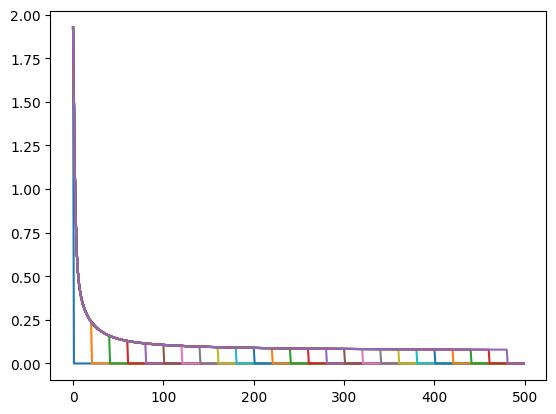

In [ ]:
# Training loop
iterations = 500
n_update = 20
t = time.time()
errorplot = np.zeros(iterations)
optimizer = optimizers.Adam(learning_rate=0.005)#(learning_rate=0.1)

for i in range(iterations):
    error = train_step(radius_array_R, optimizer)
    errorplot[i] = error

    if i % n_update == 0:
      t_now = time.time()
      print("Error: {}\tTimePerUpdate(s): {}\t {}/{}".format(error, t_now - t, i + 1, iterations))
      t = t_now
      plt.plot(errorplot)

#metasurface1_real, metasurface1_imag = tf.math.cos(metasurface1_phase), tf.math.sin(metasurface1_phase)

In [ ]:
radius_array_R = radius_array_R % pitch
radius_array_R = tf.clip_by_value(radius_array_R, radius_array_R_min, radius_array_R_max)
print(radius_array_R)

tf.Tensor(
[[0.24       0.14381333 0.24       ... 0.24       0.02448072 0.12673347]
 [0.24       0.12556869 0.24       ... 0.13050467 0.01551316 0.24      ]
 [0.10537367 0.18990634 0.13680667 ... 0.24       0.133997   0.16498159]
 ...
 [0.22835824 0.12424798 0.17552714 ... 0.15155542 0.1619963  0.17915367]
 [0.13119069 0.24       0.24       ... 0.24       0.24       0.24      ]
 [0.24       0.15991391 0.14290927 ... 0.24       0.24       0.1374844 ]], shape=(1600, 1600), dtype=float32)


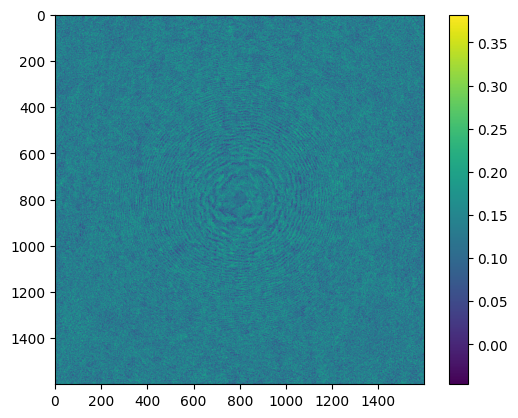

In [ ]:
plt.imshow(radius_array_R)
plt.colorbar()
#plt.imshow(metasurface1_phase[200:600,200:600])
# Save the phase
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/OptRadiusMask/OptRadiusMask_v7_7by7_no16_MO1600_numpx20/K9_neg_numpx'+str(scale*10)+'.npy',radius_array_R)

tf.Tensor(0.49870554, shape=(), dtype=float32) tf.Tensor(0.3283142, shape=(), dtype=float32) tf.Tensor(0.35529438, shape=(), dtype=float32)


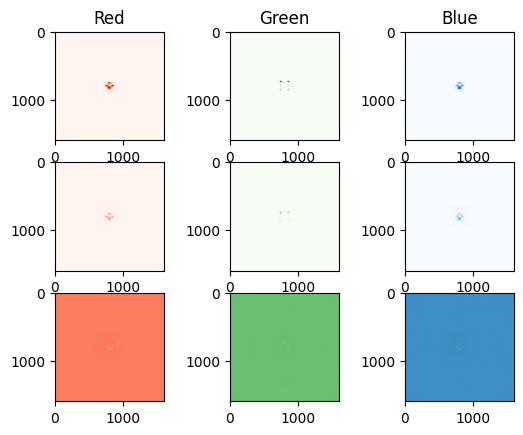

In [ ]:
propagated_fields_R, propagated_fields_G, propagated_fields_B  = forward(radius_array_R)#, metasurface2_phase
propagated_intensities_R = tf.cast(tf.math.abs(propagated_fields_R) ** 2 ,dtype=tf.float32)
propagated_intensities_G = tf.cast(tf.math.abs(propagated_fields_G) ** 2 ,dtype=tf.float32)
propagated_intensities_B = tf.cast(tf.math.abs(propagated_fields_B) ** 2 ,dtype=tf.float32)
desired_intensities_R = tf.cast(tf.math.abs(desired_psf_R), dtype=tf.float32)
desired_intensities_G = tf.cast(tf.math.abs(desired_psf_G), dtype=tf.float32)
desired_intensities_B = tf.cast(tf.math.abs(desired_psf_B), dtype=tf.float32)
propagated_intensities_R = tf.math.l2_normalize(propagated_intensities_R)
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file/K9_neg_R_numpx'+str(scale*10)+'.npy', propagated_intensities_R) # neg vs pos
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file_cropped/K9_neg_R_numpx'+str(scale*10)+'.npy', propagated_intensities_R[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])]) # neg vs pos
propagated_intensities_G = tf.math.l2_normalize(propagated_intensities_G)
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file/K9_neg_G_numpx'+str(scale*10)+'.npy', propagated_intensities_G) # neg vs pos
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file_cropped/K9_neg_G_numpx'+str(scale*10)+'.npy', propagated_intensities_G[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])]) # neg vs pos
propagated_intensities_B = tf.math.l2_normalize(propagated_intensities_B)
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file/K9_neg_B_numpx'+str(scale*10)+'.npy', propagated_intensities_B) # neg vs pos
np.save('/content/gdrive/My Drive/ConvolutionalMetaOptics/PSF/7by7_no16_MO1600_numpx20/python_file_cropped/K9_neg_B_numpx'+str(scale*10)+'.npy', propagated_intensities_B[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])]) # neg vs pos
desired_intensities_R = tf.math.l2_normalize(desired_intensities_R)
desired_intensities_G = tf.math.l2_normalize(desired_intensities_G)
desired_intensities_B = tf.math.l2_normalize(desired_intensities_B)
diff_matrix_R = tf.math.subtract(propagated_intensities_R,desired_intensities_R)
diff_matrix_G = tf.math.subtract(propagated_intensities_G,desired_intensities_G)
diff_matrix_B = tf.math.subtract(propagated_intensities_B,desired_intensities_B)
diff_matrix_R_squared = tf.square(diff_matrix_R)
diff_matrix_G_squared = tf.square(diff_matrix_G)
diff_matrix_B_squared = tf.square(diff_matrix_B)
reduce_sum_R_squared = tf.reduce_sum(diff_matrix_R_squared)
reduce_sum_G_squared = tf.reduce_sum(diff_matrix_G_squared)
reduce_sum_B_squared = tf.reduce_sum(diff_matrix_B_squared)
error_R = np.array([tf.sqrt(reduce_sum_R_squared).numpy()], dtype=np.float32)
error_G = np.array([tf.sqrt(reduce_sum_G_squared).numpy()], dtype=np.float32)
error_B = np.array([tf.sqrt(reduce_sum_B_squared).numpy()], dtype=np.float32)
error_RGB = np.array([error_R,error_G,error_B])
np.savetxt('/content/gdrive/My Drive/ConvolutionalMetaOptics/OptRadiusMask/OptRadiusMask_v7_7by7_no16_MO1600_numpx20/K9_neg_error_numpx'+str(scale*10)+'.txt', error_RGB) # neg vs pos
print(tf.sqrt(reduce_sum_R_squared),tf.sqrt(reduce_sum_G_squared),tf.sqrt(reduce_sum_B_squared))

plt.subplot(3,3,1)
plt.imshow(desired_intensities_R,cmap = 'Reds')
plt.title("Red")
plt.subplot(3,3,2)
plt.imshow(desired_intensities_G,cmap = 'Greens')
plt.title("Green")
plt.subplot(3,3,3)
plt.imshow(desired_intensities_B,cmap = 'Blues')
plt.title("Blue")

plt.subplot(3,3,4)
plt.imshow(propagated_intensities_R,cmap = 'Reds')
plt.subplot(3,3,5)
plt.imshow(propagated_intensities_G,cmap = 'Greens')
plt.subplot(3,3,6)
plt.imshow(propagated_intensities_B,cmap = 'Blues')

plt.subplot(3,3,7)
plt.imshow(diff_matrix_R,cmap = 'Reds')
plt.subplot(3,3,8)
plt.imshow(diff_matrix_G,cmap = 'Greens')
plt.subplot(3,3,9)
plt.imshow(diff_matrix_B,cmap = 'Blues')


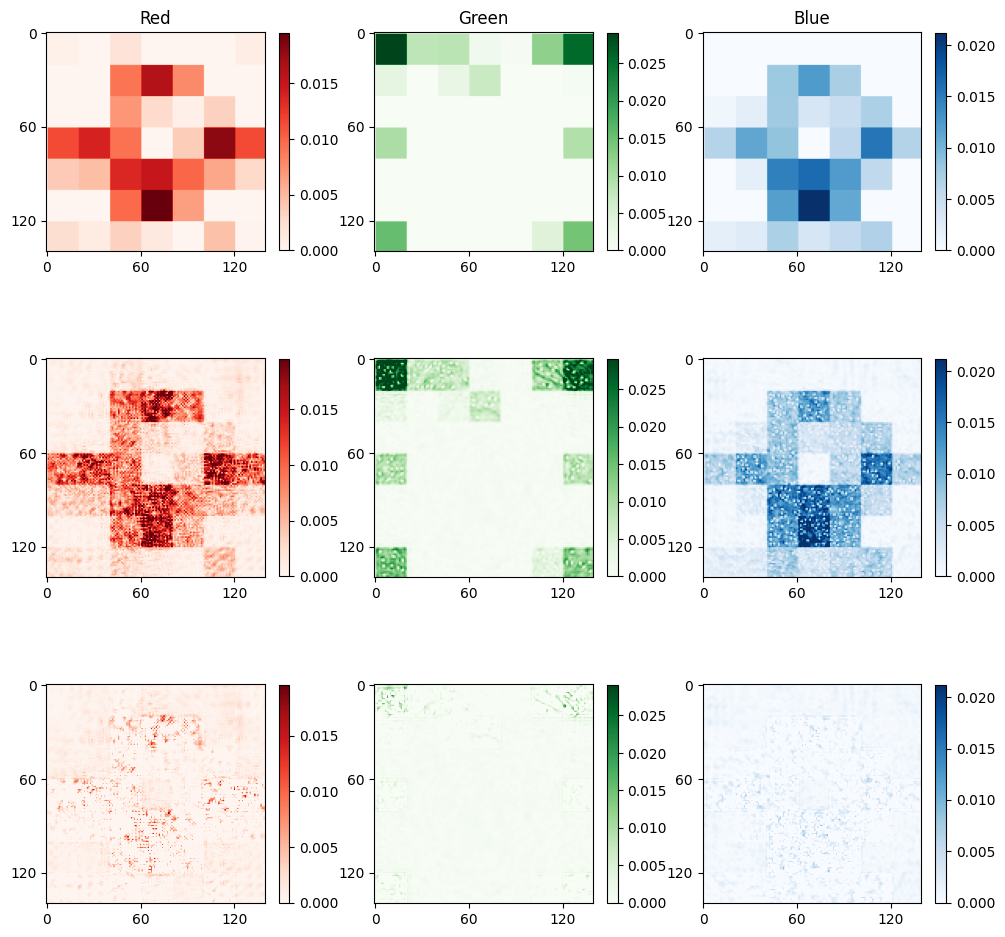

In [ ]:
plt.figure(figsize=(12, 12))

vmin=0
vmax_R = np.max(np.abs(desired_intensities_R))
vmax_G = np.max(np.abs(desired_intensities_G))
vmax_B = np.max(np.abs(desired_intensities_B))

plt.subplot(3,3,1)
desired_PSF_R = plt.imshow(desired_intensities_R[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_R, cmap = 'Reds')
plt.title("Red")
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
cbar = plt.colorbar(desired_PSF_R,shrink=0.8)

plt.subplot(3,3,2)
desired_PSF_G = plt.imshow(desired_intensities_G[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_G,cmap = 'Greens')
plt.title("Green")
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
cbar = plt.colorbar(desired_PSF_G,shrink=0.8)

plt.subplot(3,3,3)
desired_PSF_B = plt.imshow(desired_intensities_B[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_B,cmap = 'Blues')
plt.title("Blue")
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
cbar = plt.colorbar(desired_PSF_B,shrink=0.8)

plt.subplot(3,3,4)
simulated_PSF_R = plt.imshow(propagated_intensities_R[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_R,cmap = 'Reds')
cbar = plt.colorbar(simulated_PSF_R,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
plt.subplot(3,3,5)
simulated_PSF_G = plt.imshow(propagated_intensities_G[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_G,cmap = 'Greens')
cbar = plt.colorbar(simulated_PSF_G,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
plt.subplot(3,3,6)
simulated_PSF_B = plt.imshow(propagated_intensities_B[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_B,cmap = 'Blues')
cbar = plt.colorbar(simulated_PSF_B,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks

plt.subplot(3,3,7)
abs_error_R = plt.imshow(diff_matrix_R[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_R,cmap = 'Reds')
cbar = plt.colorbar(abs_error_R,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
plt.subplot(3,3,8)
abs_error_G = plt.imshow(diff_matrix_G[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_G,cmap = 'Greens')
cbar = plt.colorbar(abs_error_G,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks
plt.subplot(3,3,9)
abs_error_B = plt.imshow(diff_matrix_B[numpad-1:numpad-1 + numpx*len(kernel[0,:]),numpad-1:numpad-1 + numpx*len(kernel[0,:])], vmin=vmin, vmax=vmax_B,cmap = 'Blues')
cbar = plt.colorbar(abs_error_B,shrink=0.8)
plt.xticks([0,scale*30,scale*60])  # Remove x-axis ticks
plt.yticks([0,scale*30,scale*60])  # Remove y-axis ticks

plt.savefig(f"{'/content/gdrive/My Drive/ConvolutionalMetaOptics/OptRadiusMask/OptRadiusMask_v7_7by7_no16_MO1600_numpx20'}/{'K9_neg_numpx'+str(scale*10)+'.jpg'}")
